In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Speech2025Datasets/vox2/vox2_test_aac.zip"
extract_path = "/content/vox2_aac"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Extraction complete.")

 Extraction complete.


In [3]:
from pathlib import Path
from tqdm import tqdm

input_root = "/content/vox2_aac/aac"
output_root = "/content/vox2_wav"

os.makedirs(output_root, exist_ok=True)

aac_files = list(Path(input_root).rglob("*.m4a"))

print(f"Total AAC files found: {len(aac_files)}")

for aac_path in tqdm(aac_files[:]):
    rel_path = aac_path.relative_to(input_root).with_suffix('.wav')
    wav_path = Path(output_root) / rel_path

    wav_path.parent.mkdir(parents=True, exist_ok=True)

    os.system(f"ffmpeg -i '{aac_path}' -ar 16000 -ac 1 -loglevel error '{wav_path}'")

Total AAC files found: 36237


100%|██████████| 36237/36237 [1:26:14<00:00,  7.00it/s]


In [4]:
wav_root = "/content/vox2_wav"
output_root = "/content/egemaps_features_vox2"
os.makedirs(output_root, exist_ok=True)

In [5]:
!chmod +x /content/opensmile/build/progsrc/smilextract/SMILExtract
!/content/opensmile/build/progsrc/smilextract/SMILExtract -h

chmod: cannot access '/content/opensmile/build/progsrc/smilextract/SMILExtract': No such file or directory
/bin/bash: line 1: /content/opensmile/build/progsrc/smilextract/SMILExtract: No such file or directory


In [6]:
!git clone https://github.com/audeering/opensmile.git
%cd opensmile
!mkdir build && cd build && cmake .. && make -j4

Cloning into 'opensmile'...
remote: Enumerating objects: 1830, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 1830 (delta 19), reused 15 (delta 15), pack-reused 1793 (from 2)
Receiving objects: 100% (1830/1830), 10.78 MiB | 7.75 MiB/s, done.
Resolving deltas: 100% (693/693), done.
/content/opensmile
CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value.  Or, use the <min>...<max> syntax
  to tell CMake that the project requires at least <min> but has been updated
  to work with policies introduced by <max> or earlier.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- De

In [7]:
smile_path = "/content/opensmile/build/progsrc/smilextract/SMILExtract"
config_path = "/content/opensmile/config/egemaps/v02/eGeMAPSv02.conf"

In [8]:
test_wav = "/content/vox2_wav/id00017/01dfn2spqyE/00001.wav"
test_csv = "/content/egemaps_features_vox2/test_output.csv"

cmd = f"{smile_path} -C {config_path} -I '{test_wav}' -O '{test_csv}' -nologfile -noconsoleoutput"
print("CMD:", cmd)

import subprocess
result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)

import os
print("File created:", os.path.exists(test_csv))

CMD: /content/opensmile/build/progsrc/smilextract/SMILExtract -C /content/opensmile/config/egemaps/v02/eGeMAPSv02.conf -I '/content/vox2_wav/id00017/01dfn2spqyE/00001.wav' -O '/content/egemaps_features_vox2/test_output.csv' -nologfile -noconsoleoutput
STDOUT: 
STDERR: 
File created: True


In [10]:
import pandas as pd
import numpy as np

csv_root = "/content/egemaps_features_vox2"
csv_files = []

for root, _, files in os.walk(csv_root):
    for file in files:
        if file.lower().endswith(".csv"):
            csv_files.append(os.path.join(root, file))

print("Total CSV files:", len(csv_files))
print("Sample:", csv_files[:5])

X = []
for csv_path in tqdm(csv_files):
    df = pd.read_csv(csv_path, sep=';')
    df = df.drop(columns=["name"], errors="ignore")
    X.append(df.values[0])

X = np.array(X)
print("Shape of X:", X.shape)

Total CSV files: 1
Sample: ['/content/egemaps_features_vox2/test_output.csv']


100%|██████████| 1/1 [00:00<00:00, 19.99it/s]

Shape of X: (1, 1)


In [11]:
smile_exec = "/content/opensmile/build/progsrc/smilextract/SMILExtract"
config_path = "/content/opensmile/config/egemaps/v02/eGeMAPSv02.conf"
output_dir = "/content/egemaps_features_vox2"

os.makedirs(output_dir, exist_ok=True)

wav_root = "/content/vox2_wav"
wav_files = list(Path(wav_root).rglob("*.wav"))
print(f"Total WAV files found: {len(wav_files)}")

count = 0

for wav_path in tqdm(wav_files[:5000]):
    name = "wav_" + "_".join(str(wav_path).split("/")[-3:]).replace(".wav", ".csv")
    output_path = os.path.join(output_dir, name)

    cmd = f'{smile_exec} -C {config_path} -I "{wav_path}" -csvoutput "{output_path}" -appendcsv 0 -timestampcsv 0 -headercsv 1 -nologfile -noconsoleoutput'

    os.system(cmd)
    count += 1

    if count % 100 == 0:
        print(f"Processed {count} files")

print("Feature extraction completed.")

Total WAV files found: 36237


 10%|█         | 100/1000 [00:26<04:43,  3.17it/s]

Processed 100 files


 20%|██        | 200/1000 [00:51<03:10,  4.20it/s]

Processed 200 files


 30%|███       | 300/1000 [01:23<05:31,  2.11it/s]

Processed 300 files


 40%|████      | 401/1000 [01:57<01:55,  5.20it/s]

Processed 400 files


 50%|█████     | 500/1000 [02:33<02:22,  3.50it/s]

Processed 500 files


 60%|██████    | 601/1000 [03:08<01:14,  5.33it/s]

Processed 600 files


 70%|███████   | 701/1000 [03:42<01:31,  3.27it/s]

Processed 700 files


 80%|████████  | 800/1000 [04:09<00:36,  5.51it/s]

Processed 800 files


 90%|█████████ | 900/1000 [04:30<00:24,  4.06it/s]

Processed 900 files


100%|██████████| 1000/1000 [04:56<00:00,  3.38it/s]

Processed 1000 files
Feature extraction completed.


In [13]:
smile_exec = "/content/opensmile/build/progsrc/smilextract/SMILExtract"
config_path = "/content/opensmile/config/egemaps/v02/eGeMAPSv02.conf"
output_dir = "/content/egemaps_features_vox2"

os.makedirs(output_dir, exist_ok=True)

wav_root = "/content/vox2_wav"
wav_files = list(Path(wav_root).rglob("*.wav"))
print(f"Total WAV files found: {len(wav_files)}")

count = 0

for wav_path in tqdm(wav_files[:10000]):
    name = "wav_" + "_".join(str(wav_path).split("/")[-3:]).replace(".wav", ".csv")
    output_path = os.path.join(output_dir, name)

    cmd = f'{smile_exec} -C {config_path} -I "{wav_path}" -csvoutput "{output_path}" -appendcsv 0 -timestampcsv 0 -headercsv 1 -nologfile -noconsoleoutput'

    os.system(cmd)

    count += 1

    if count % 100 == 0:
        print(f"Processed {count} files")

print("Feature extraction completed.")

Total WAV files found: 36237


  1%|          | 100/10000 [00:27<33:42,  4.90it/s]

Processed 100 files


  2%|▏         | 200/10000 [00:59<56:46,  2.88it/s]  

Processed 200 files


  3%|▎         | 301/10000 [01:29<47:58,  3.37it/s]

Processed 300 files


  4%|▍         | 401/10000 [02:03<31:48,  5.03it/s]

Processed 400 files


  5%|▌         | 501/10000 [02:40<34:00,  4.66it/s]

Processed 500 files


  6%|▌         | 601/10000 [03:14<29:22,  5.33it/s]

Processed 600 files


  7%|▋         | 700/10000 [03:48<1:07:45,  2.29it/s]

Processed 700 files


  8%|▊         | 800/10000 [04:14<28:53,  5.31it/s]

Processed 800 files


  9%|▉         | 900/10000 [04:36<25:06,  6.04it/s]

Processed 900 files


 10%|█         | 1000/10000 [05:02<39:58,  3.75it/s]

Processed 1000 files


 11%|█         | 1100/10000 [05:35<43:57,  3.37it/s]

Processed 1100 files


 12%|█▏        | 1201/10000 [06:17<40:41,  3.60it/s]

Processed 1200 files


 13%|█▎        | 1300/10000 [06:52<33:24,  4.34it/s]

Processed 1300 files


 14%|█▍        | 1400/10000 [07:24<45:08,  3.17it/s]

Processed 1400 files


 15%|█▌        | 1501/10000 [08:00<31:04,  4.56it/s]

Processed 1500 files


 16%|█▌        | 1600/10000 [08:29<44:22,  3.15it/s]

Processed 1600 files


 17%|█▋        | 1700/10000 [08:56<48:40,  2.84it/s]

Processed 1700 files


 18%|█▊        | 1800/10000 [09:24<33:43,  4.05it/s]

Processed 1800 files


 19%|█▉        | 1901/10000 [09:56<25:36,  5.27it/s]

Processed 1900 files


 20%|██        | 2000/10000 [10:27<52:09,  2.56it/s]

Processed 2000 files


 21%|██        | 2100/10000 [10:55<31:39,  4.16it/s]

Processed 2100 files


 22%|██▏       | 2201/10000 [11:28<36:08,  3.60it/s]

Processed 2200 files


 23%|██▎       | 2301/10000 [11:56<22:21,  5.74it/s]

Processed 2300 files


 24%|██▍       | 2401/10000 [12:23<23:19,  5.43it/s]

Processed 2400 files


 25%|██▌       | 2500/10000 [12:48<27:56,  4.47it/s]

Processed 2500 files


 26%|██▌       | 2600/10000 [13:19<36:57,  3.34it/s]

Processed 2600 files


 27%|██▋       | 2701/10000 [13:45<22:15,  5.46it/s]

Processed 2700 files


 28%|██▊       | 2800/10000 [14:13<57:40,  2.08it/s]

Processed 2800 files


 29%|██▉       | 2900/10000 [14:42<38:30,  3.07it/s]

Processed 2900 files


 30%|███       | 3000/10000 [15:10<34:21,  3.40it/s]

Processed 3000 files


 31%|███       | 3100/10000 [15:34<28:33,  4.03it/s]

Processed 3100 files


 32%|███▏      | 3201/10000 [16:02<24:30,  4.62it/s]

Processed 3200 files


 33%|███▎      | 3300/10000 [16:35<55:43,  2.00it/s]

Processed 3300 files


 34%|███▍      | 3400/10000 [17:03<45:07,  2.44it/s]

Processed 3400 files


 35%|███▌      | 3501/10000 [17:30<31:47,  3.41it/s]

Processed 3500 files


 36%|███▌      | 3601/10000 [17:59<20:09,  5.29it/s]

Processed 3600 files


 37%|███▋      | 3700/10000 [18:28<24:15,  4.33it/s]

Processed 3700 files


 38%|███▊      | 3800/10000 [19:03<27:17,  3.79it/s]

Processed 3800 files


 39%|███▉      | 3900/10000 [19:40<27:59,  3.63it/s]

Processed 3900 files


 40%|████      | 4000/10000 [20:10<29:13,  3.42it/s]

Processed 4000 files


 41%|████      | 4101/10000 [20:46<23:21,  4.21it/s]

Processed 4100 files


 42%|████▏     | 4201/10000 [21:15<30:37,  3.16it/s]

Processed 4200 files


 43%|████▎     | 4300/10000 [21:45<26:39,  3.56it/s]

Processed 4300 files


 44%|████▍     | 4401/10000 [22:16<21:35,  4.32it/s]

Processed 4400 files


 45%|████▌     | 4500/10000 [22:47<23:24,  3.92it/s]

Processed 4500 files


 46%|████▌     | 4600/10000 [23:15<25:01,  3.60it/s]

Processed 4600 files


 47%|████▋     | 4700/10000 [23:49<19:44,  4.47it/s]

Processed 4700 files


 48%|████▊     | 4800/10000 [24:22<30:49,  2.81it/s]

Processed 4800 files


 49%|████▉     | 4901/10000 [24:59<15:47,  5.38it/s]

Processed 4900 files


 50%|█████     | 5000/10000 [25:41<43:03,  1.94it/s]

Processed 5000 files


 51%|█████     | 5100/10000 [26:26<23:55,  3.41it/s]

Processed 5100 files


 52%|█████▏    | 5201/10000 [26:58<22:54,  3.49it/s]

Processed 5200 files


 53%|█████▎    | 5300/10000 [27:28<15:50,  4.95it/s]

Processed 5300 files


 54%|█████▍    | 5401/10000 [28:03<24:42,  3.10it/s]

Processed 5400 files


 55%|█████▌    | 5501/10000 [28:37<20:28,  3.66it/s]

Processed 5500 files


 56%|█████▌    | 5600/10000 [29:13<35:59,  2.04it/s]

Processed 5600 files


 57%|█████▋    | 5700/10000 [29:50<19:02,  3.76it/s]

Processed 5700 files


 58%|█████▊    | 5801/10000 [30:27<18:14,  3.84it/s]

Processed 5800 files


 59%|█████▉    | 5900/10000 [31:03<15:40,  4.36it/s]

Processed 5900 files


 60%|██████    | 6000/10000 [31:37<21:22,  3.12it/s]

Processed 6000 files


 61%|██████    | 6100/10000 [32:03<12:57,  5.02it/s]

Processed 6100 files


 62%|██████▏   | 6201/10000 [32:31<11:56,  5.30it/s]

Processed 6200 files


 63%|██████▎   | 6301/10000 [32:56<10:53,  5.66it/s]

Processed 6300 files


 64%|██████▍   | 6400/10000 [33:19<19:25,  3.09it/s]

Processed 6400 files


 65%|██████▌   | 6501/10000 [33:54<16:28,  3.54it/s]

Processed 6500 files


 66%|██████▌   | 6600/10000 [34:25<17:40,  3.20it/s]

Processed 6600 files


 67%|██████▋   | 6700/10000 [34:55<16:36,  3.31it/s]

Processed 6700 files


 68%|██████▊   | 6800/10000 [35:25<10:17,  5.18it/s]

Processed 6800 files


 69%|██████▉   | 6900/10000 [35:52<10:39,  4.85it/s]

Processed 6900 files


 70%|███████   | 7000/10000 [36:24<10:37,  4.71it/s]

Processed 7000 files


 71%|███████   | 7100/10000 [36:55<10:21,  4.67it/s]

Processed 7100 files


 72%|███████▏  | 7201/10000 [37:26<10:57,  4.25it/s]

Processed 7200 files


 73%|███████▎  | 7300/10000 [37:51<10:05,  4.46it/s]

Processed 7300 files


 74%|███████▍  | 7400/10000 [38:19<11:02,  3.93it/s]

Processed 7400 files


 75%|███████▌  | 7501/10000 [38:45<08:45,  4.75it/s]

Processed 7500 files


 76%|███████▌  | 7600/10000 [39:11<17:18,  2.31it/s]

Processed 7600 files


 77%|███████▋  | 7700/10000 [39:37<09:02,  4.24it/s]

Processed 7700 files


 78%|███████▊  | 7800/10000 [40:07<11:54,  3.08it/s]

Processed 7800 files


 79%|███████▉  | 7900/10000 [40:39<13:44,  2.55it/s]

Processed 7900 files


 80%|████████  | 8001/10000 [41:03<05:32,  6.02it/s]

Processed 8000 files


 81%|████████  | 8100/10000 [41:28<06:41,  4.73it/s]

Processed 8100 files


 82%|████████▏ | 8201/10000 [41:57<06:32,  4.58it/s]

Processed 8200 files


 83%|████████▎ | 8300/10000 [42:34<15:29,  1.83it/s]

Processed 8300 files


 84%|████████▍ | 8400/10000 [43:12<06:14,  4.27it/s]

Processed 8400 files


 85%|████████▌ | 8500/10000 [43:45<05:45,  4.34it/s]

Processed 8500 files


 86%|████████▌ | 8600/10000 [44:22<07:27,  3.13it/s]

Processed 8600 files


 87%|████████▋ | 8700/10000 [44:48<08:56,  2.42it/s]

Processed 8700 files


 88%|████████▊ | 8800/10000 [45:21<04:28,  4.47it/s]

Processed 8800 files


 89%|████████▉ | 8900/10000 [45:53<06:50,  2.68it/s]

Processed 8900 files


 90%|█████████ | 9001/10000 [46:24<03:24,  4.90it/s]

Processed 9000 files


 91%|█████████ | 9100/10000 [46:58<09:15,  1.62it/s]

Processed 9100 files


 92%|█████████▏| 9200/10000 [47:35<07:17,  1.83it/s]

Processed 9200 files


 93%|█████████▎| 9300/10000 [48:09<03:51,  3.02it/s]

Processed 9300 files


 94%|█████████▍| 9400/10000 [48:36<03:19,  3.01it/s]

Processed 9400 files


 95%|█████████▌| 9500/10000 [49:05<01:45,  4.74it/s]

Processed 9500 files


 96%|█████████▌| 9600/10000 [49:33<01:25,  4.67it/s]

Processed 9600 files


 97%|█████████▋| 9700/10000 [50:00<01:14,  4.00it/s]

Processed 9700 files


 98%|█████████▊| 9800/10000 [50:33<01:00,  3.31it/s]

Processed 9800 files


 99%|█████████▉| 9901/10000 [51:00<00:25,  3.89it/s]

Processed 9900 files


100%|██████████| 10000/10000 [51:28<00:00,  3.24it/s]

Processed 10000 files
Feature extraction completed.


In [14]:
output_folder = "/content/egemaps_features_vox2"
csv_files = list(Path(output_folder).rglob("*.csv"))

print(f"Total CSV files found: {len(csv_files)}")
print(f"Sample files: {csv_files[:5]}")

sample_csv = csv_files[0]
df = pd.read_csv(sample_csv, sep=";")
print(f"Sample CSV Shape: {df.shape}")
print(f"Sample CSV Columns: {df.columns}")
print(f"Sample CSV Head:\n{df.head()}")

Total CSV files found: 10001
Sample files: [PosixPath('/content/egemaps_features_vox2/wav_id07621_TwoL4k9wih4_00248.csv'), PosixPath('/content/egemaps_features_vox2/wav_id05055_g-9k9_PcxVY_00390.csv'), PosixPath('/content/egemaps_features_vox2/wav_id07620_axaQeZdVOgM_00345.csv'), PosixPath('/content/egemaps_features_vox2/wav_id07620_VqsFp0J22Hc_00191.csv'), PosixPath('/content/egemaps_features_vox2/wav_id01333_sDvzX9Nm0Bk_00406.csv')]
Sample CSV Shape: (1, 89)
Sample CSV Columns: Index(['name', 'F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_std

In [16]:
feature_folder = "/content/egemaps_features_vox2"
csv_files = sorted([f for f in os.listdir(feature_folder) if f.endswith(".csv")])
print("Total CSV files found:", len(csv_files))

X = []
bad_files = []

for f in tqdm(csv_files):
    try:
        df = pd.read_csv(os.path.join(feature_folder, f), delimiter=';')
        if df.shape != (1, 89):
            bad_files.append(f)
            continue
        feature_row = df.iloc[0].values[1:].astype(float)
        X.append(feature_row)
    except Exception as e:
        print(f"Skipping {f} due to error: {e}")
        bad_files.append(f)

X = np.stack(X)
print(" Final shape of X:", X.shape)
print(f" Skipped {len(bad_files)} bad files")


Total CSV files found: 10001


100%|██████████| 10001/10001 [00:37<00:00, 268.07it/s]

 Final shape of X: (10000, 88)
 Skipped 1 bad files


Total CSV files found: 10001
Sample files: ['test_output.csv', 'wav_id00812_1Xfgvdu7oDo_00001.csv', 'wav_id00812_1Xfgvdu7oDo_00002.csv', 'wav_id00812_1Xfgvdu7oDo_00003.csv', 'wav_id00812_1Xfgvdu7oDo_00004.csv']


100%|██████████| 10001/10001 [00:42<00:00, 237.94it/s]


Final shape of X: (10000, 88)
Skipped 1 bad files
Bad file samples: ['test_output.csv']
Sample arousal (0–1): [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
Sample valence (0–1): [0.37364082 0.3329121  0.17615391 0.60726667 0.47662416]


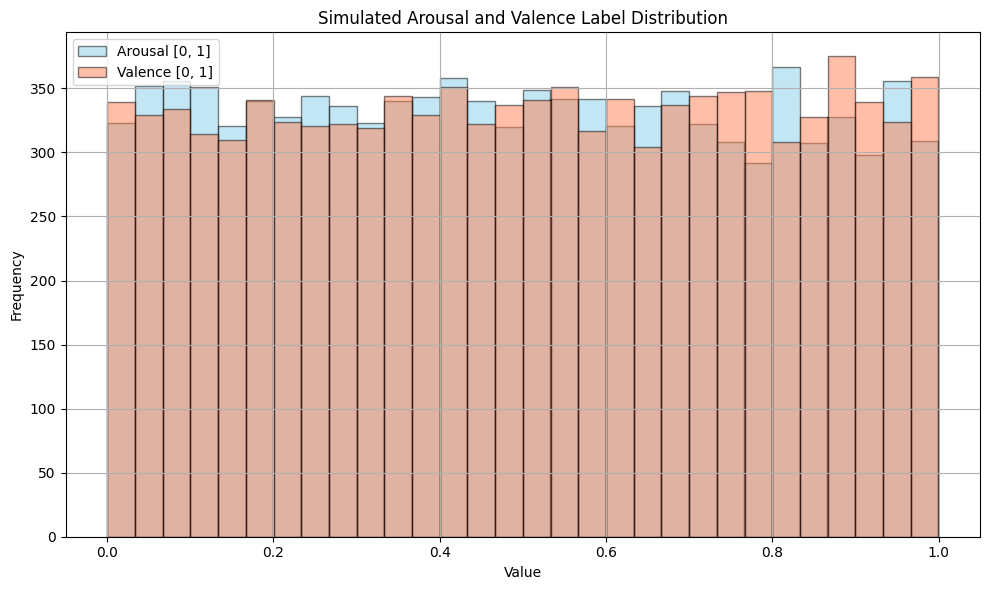

 All arrays saved successfully with updated [0, 1] label range.


In [38]:
import matplotlib.pyplot as plt

# === Step 1: Load eGeMAPS features from CSVs ===
feature_folder = "/content/egemaps_features_vox2"
csv_files = sorted([f for f in os.listdir(feature_folder) if f.endswith(".csv")])
print("Total CSV files found:", len(csv_files))
print("Sample files:", csv_files[:5])

X = []
bad_files = []

for f in tqdm(csv_files):
    try:
        df = pd.read_csv(os.path.join(feature_folder, f), delimiter=';')
        row = df.iloc[0].values[1:].astype(float)  # exclude timestamp
        if len(row) == 88:
            X.append(row)
        else:
            bad_files.append(f)
    except Exception as e:
        bad_files.append(f)

X = np.stack(X)
print("Final shape of X:", X.shape)
print(f"Skipped {len(bad_files)} bad files")
if bad_files:
    print("Bad file samples:", bad_files[:3])

# === Step 2: Simulate Arousal and Valence in [0, 1] ===
np.random.seed(42)
arousal = np.random.uniform(0, 1, size=X.shape[0])
valence = np.random.uniform(0, 1, size=X.shape[0])

print("Sample arousal (0–1):", arousal[:5])
print("Sample valence (0–1):", valence[:5])

# === Step 3: Plot Distribution ===
plt.figure(figsize=(10, 6))
plt.hist(arousal, bins=30, alpha=0.5, label='Arousal [0, 1]', color='skyblue', edgecolor='black')
plt.hist(valence, bins=30, alpha=0.5, label='Valence [0, 1]', color='coral', edgecolor='black')
plt.title("Simulated Arousal and Valence Label Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 4: Save Arrays ===
np.save("/content/X_vox2.npy", X)
np.save("/content/arousal_vox2.npy", arousal)
np.save("/content/valence_vox2.npy", valence)

print(" All arrays saved successfully with updated [0, 1] label range.")

In [39]:
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# === Load Features & Labels ===
X = np.load("/content/X_vox2.npy")[:100]
y = np.load("/content/arousal_vox2.npy")[:100]

# === Reshape for LSTM input ===
X = X[:, np.newaxis, :]

# === Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Define Model ===
model_lstm = models.Sequential([
    layers.Input(shape=(1, 88)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

# === Train ===
history_lstm = model_lstm.fit(X_train, y_train, epochs=70, batch_size=3, validation_data=(X_test, y_test))

# === Evaluate ===
mse_lstm = model_lstm.evaluate(X_test, y_test)
print("LSTM Test MSE:", mse_lstm)

def concordance_correlation_coefficient(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cor, _ = pearsonr(y_true, y_pred)
    return (2 * cor * np.sqrt(var_true) * np.sqrt(var_pred)) / (var_true + var_pred + (mean_true - mean_pred)**2)

# Predict and compute CCC
y_pred = model_lstm.predict(X_test).flatten()
ccc = concordance_correlation_coefficient(y_test, y_pred)
print("LSTM Test CCC:", round(ccc, 4))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 1, 64)          │        39,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,257 (282.25 KB)

 Trainable params: 72,257 (282.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0924 - val_loss: 0.0995
Epoch 2/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0726 - val_loss: 0.0989
Epoch 3/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0821 - val_loss: 0.0995
Epoch 4/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0827 - val_loss: 0.0989
Epoch 5/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0833 - val_loss: 0.0986
Epoch 6/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0855 - val_loss: 0.0989
Epoch 7/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0720 - val_loss: 0.0990
Epoch 8/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0908 - val_loss: 0.0992
Epoch 9/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0822 - val_loss: 0.0989
Epoch 10/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0878 - val_loss: 0.0990
Epoch 11/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0724 - val_loss: 0.1000
Epoch 12/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0859 -

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Input
from sklearn.model_selection import train_test_split

# === Load Features & Labels ===
X = np.load("/content/X_vox2.npy")[:100]             # shape: (100, 88)
y = np.load("/content/arousal_vox2.npy")[:100]       # shape: (100,)

# === Reshape for Conv1D input (batch, time, features) ===
X = X[:, np.newaxis, :]  # Now shape: (100, 1, 88)

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === TDNN Model ===
model_tdnn = Sequential([
    Input(shape=(1, 88)),
    Conv1D(64, kernel_size=3, padding='same', activation='relu', dilation_rate=1),
    Conv1D(64, kernel_size=3, padding='same', activation='relu', dilation_rate=2),
    Conv1D(64, kernel_size=3, padding='same', activation='relu', dilation_rate=3),
    Conv1D(64, kernel_size=3, padding='same', activation='relu', dilation_rate=4),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')  # bounded output in [0, 1]
])

model_tdnn.compile(optimizer='adam', loss='mse')
model_tdnn.summary()

# === Train ===
history_tdnn = model_tdnn.fit(X_train, y_train, epochs=70, batch_size=3, validation_data=(X_test, y_test))

# === Evaluate ===
loss_tdnn = model_tdnn.evaluate(X_test, y_test)
print("TDNN Test MSE:", loss_tdnn)

# === CCC Calculation ===
from scipy.stats import pearsonr

def concordance_correlation_coefficient(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cor, _ = pearsonr(y_true, y_pred)
    return (2 * cor * np.sqrt(var_true) * np.sqrt(var_pred)) / (var_true + var_pred + (mean_true - mean_pred)**2)

# Predict and compute CCC
y_pred = model_tdnn.predict(X_test).flatten()
ccc = concordance_correlation_coefficient(y_test, y_pred)
print("TDNN Test CCC:", round(ccc, 4))

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 1, 64)          │        16,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 1, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 1, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 1, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,081 (211.25 KB)

 Trainable params: 54,081 (211.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.3064 - val_loss: 0.3277
Epoch 2/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3285 - val_loss: 0.3277
Epoch 3/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3012 - val_loss: 0.3277
Epoch 4/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3277 - val_loss: 0.3277
Epoch 5/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2750 - val_loss: 0.3277
Epoch 6/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3258 - val_loss: 0.3277
Epoch 7/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3120 - val_loss: 0.3277
Epoch 8/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2984 - val_loss: 0.3277
Epoch 9/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3229 - val_loss: 0.3277
Epoch 10/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2929 - val_loss: 0.3277
Epoch 11/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3053 - val_loss: 0.3277
Epoch 12/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3253 - val_

In [41]:
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import pearsonr

# === Load Features & Labels ===
X = np.load("/content/X_vox2.npy")[:100]
y = np.load("/content/arousal_vox2.npy")[:100]

# === Reshape for MHA input ===
X = X[:, np.newaxis, :]  # shape: (100, 1, 88)

# === Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Build Multi-Head Attention Model ===
def build_attention_model():
    inp = Input(shape=(1, 88))

    x = MultiHeadAttention(num_heads=4, key_dim=16)(inp, inp)
    x = LayerNormalization()(x)
    x = Dense(64, activation='relu')(x)

    x = MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
    x = LayerNormalization()(x)
    x = Dense(64, activation='relu')(x)

    x = GlobalAveragePooling1D()(x)
    out = Dense(1, activation='sigmoid')(x)  # match [0, 1] range

    return Model(inputs=inp, outputs=out)

model_attn = build_attention_model()
model_attn.compile(optimizer='adam', loss='mse')
model_attn.summary()

# === Train ===
history_attn = model_attn.fit(X_train, y_train, epochs=70, batch_size=3, validation_data=(X_test, y_test))

# === Evaluate ===
loss_attn = model_attn.evaluate(X_test, y_test)
print("Attention Test MSE:", loss_attn)

# === CCC Calculation ===
def concordance_correlation_coefficient(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cor, _ = pearsonr(y_true, y_pred)
    return (2 * cor * np.sqrt(var_true) * np.sqrt(var_pred)) / (var_true + var_pred + (mean_true - mean_pred)**2)

# Predict and compute CCC
y_pred = model_attn.predict(X_test).flatten()
ccc = concordance_correlation_coefficient(y_test, y_pred)
print("Attention Test CCC:", round(ccc, 4))

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1, 88)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 88)     │     22,808 │ input_layer_12[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 88)     │        176 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1, 64)     │      5,696 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 64)     │     16,640 │ dense_13[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1, 64)     │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         65 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,673 (194.04 KB)

 Trainable params: 49,673 (194.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.1645 - val_loss: 0.1049
Epoch 2/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0830 - val_loss: 0.0989
Epoch 3/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0903 - val_loss: 0.0991
Epoch 4/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0847 - val_loss: 0.1044
Epoch 5/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0958 - val_loss: 0.1052
Epoch 6/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0987 - val_loss: 0.0994
Epoch 7/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0900 - val_loss: 0.1006
Epoch 8/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0832 - val_loss: 0.1081
Epoch 9/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0878 - val_loss: 0.1027
Epoch 10/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1139 - val_loss: 0.1012
Epoch 11/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0866 - val_loss: 0.1008
Epoch 12/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0989 - va

In [44]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

# === Load Features & Labels ===
X = np.load("/content/X_vox2.npy")[:100]
y = np.load("/content/arousal_vox2.npy")[:100]  # In [0, 1]

# === Reshape for temporal input ===
X = X[:, np.newaxis, :]  # shape: (100, 1, 88)

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === TDNN + LSTM Model ===
def build_tdnn_lstm_model():
    inp = Input(shape=(1, 88))

    # TDNN block
    x = Conv1D(64, kernel_size=1, activation='relu', padding='same')(inp)
    x = Conv1D(64, kernel_size=1, activation='relu', padding='same')(x)
    x = Conv1D(64, kernel_size=1, activation='relu', padding='same')(x)
    x = Conv1D(64, kernel_size=1, activation='relu', padding='same')(x)

    # LSTM block
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)

    # Output layer with sigmoid for [0, 1] range
    out = Dense(1, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=out)

model_tdnn_lstm = build_tdnn_lstm_model()
model_tdnn_lstm.compile(optimizer='adam', loss='mse')
model_tdnn_lstm.summary()

# === Train ===
history_tdnn_lstm = model_tdnn_lstm.fit(
    X_train, y_train,
    epochs=70,
    batch_size=3,
    validation_data=(X_test, y_test)
)

# === Evaluate ===
loss_tdnn_lstm = model_tdnn_lstm.evaluate(X_test, y_test)
print("TDNN + LSTM Test MSE:", loss_tdnn_lstm)

# === CCC Calculation with safety check ===
def concordance_correlation_coefficient(y_true, y_pred):
    std_true = np.std(y_true)
    std_pred = np.std(y_pred)

    if std_true == 0 or std_pred == 0:
        print(" One of the inputs is constant. CCC is undefined.")
        return float('nan')

    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cor, _ = pearsonr(y_true, y_pred)

    return (2 * cor * np.sqrt(var_true) * np.sqrt(var_pred)) / \
           (var_true + var_pred + (mean_true - mean_pred) ** 2)

# Predict
y_pred = model_tdnn_lstm.predict(X_test).flatten()
ccc = concordance_correlation_coefficient(y_test, y_pred)
print("TDNN + LSTM Test CCC:", round(ccc, 4))

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 1, 88)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 1, 64)          │         5,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 1, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 1, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 1, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,289 (329.25 KB)

 Trainable params: 84,289 (329.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0926 - val_loss: 0.0981
Epoch 2/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0988 - val_loss: 0.0988
Epoch 3/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0742 - val_loss: 0.0991
Epoch 4/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0694 - val_loss: 0.0991
Epoch 5/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0836 - val_loss: 0.0988
Epoch 6/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0809 - val_loss: 0.0987
Epoch 7/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0985 - val_loss: 0.0986
Epoch 8/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0952 - val_loss: 0.0990
Epoch 9/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0902 - val_loss: 0.0990
Epoch 10/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0897 - val_loss: 0.0987
Epoch 11/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0847 - val_loss: 0.0988
Epoch 12/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0847

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
TDNN + LSTM Test CCC: -0.0


In [45]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Conv1D, GlobalAveragePooling1D, Dense
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

# === Load Features & Labels ===
X = np.load("/content/X_vox2.npy")[:100]
y = np.load("/content/arousal_vox2.npy")[:100]

# === Reshape for time-distributed input ===
X = X[:, np.newaxis, :]  # shape: (100, 1, 88)

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Define Attention + TDNN Model ===
def build_attention_tdnn_model():
    inp = Input(shape=(1, 88))

    # Attention block
    x = MultiHeadAttention(num_heads=4, key_dim=22)(inp, inp)
    x = LayerNormalization()(x)

    # TDNN block (4 Conv1D layers with kernel_size=1)
    for _ in range(4):
        x = Conv1D(64, kernel_size=1, activation='relu', padding='same')(x)

    # Global pooling and output
    x = GlobalAveragePooling1D()(x)
    out = Dense(1, activation='sigmoid')(x)  # match [0, 1]

    return Model(inputs=inp, outputs=out)

model_attn_tdnn = build_attention_tdnn_model()
model_attn_tdnn.compile(optimizer='adam', loss='mse')
model_attn_tdnn.summary()

# === Train ===
history_attn_tdnn = model_attn_tdnn.fit(X_train, y_train, epochs=70, batch_size=3, validation_data=(X_test, y_test))

# === Evaluate ===
loss_attn_tdnn = model_attn_tdnn.evaluate(X_test, y_test)
print("Attention + TDNN Test MSE:", loss_attn_tdnn)

# === CCC Calculation with Safety Check ===
def concordance_correlation_coefficient(y_true, y_pred):
    std_true = np.std(y_true)
    std_pred = np.std(y_pred)
    if std_true == 0 or std_pred == 0:
        print(" CCC undefined: constant input")
        return float('nan')

    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cor, _ = pearsonr(y_true, y_pred)

    return (2 * cor * np.sqrt(var_true) * np.sqrt(var_pred)) / \
           (var_true + var_pred + (mean_true - mean_pred) ** 2)

# === Predict and Compute CCC ===
y_pred = model_attn_tdnn.predict(X_test).flatten()
ccc = concordance_correlation_coefficient(y_test, y_pred)
print("Attention + TDNN Test CCC:", round(ccc, 4))

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 1, 88)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 88)     │     31,328 │ input_layer_16[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 88)     │        176 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 1, 64)     │      5,696 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 1, 64)     │      4,160 │ conv1d_44[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 1, 64)     │      4,160 │ conv1d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 1, 64)     │      4,160 │ conv1d_46[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_47[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         65 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,745 (194.32 KB)

 Trainable params: 49,745 (194.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0929 - val_loss: 0.1065
Epoch 2/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0718 - val_loss: 0.1010
Epoch 3/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0849 - val_loss: 0.0991
Epoch 4/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0976 - val_loss: 0.1043
Epoch 5/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1056 - val_loss: 0.1028
Epoch 6/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0850 - val_loss: 0.1008
Epoch 7/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0857 - val_loss: 0.0987
Epoch 8/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0770 - val_loss: 0.0997
Epoch 9/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0907 - val_loss: 0.0990
Epoch 10/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0923 - val_loss: 0.0989
Epoch 11/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0845 - val_loss: 0.1011
Epoch 12/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1003 

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, LSTM, Dense
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

# === Load Features & Labels ===
X = np.load("/content/X_vox2.npy")[:100]
y = np.load("/content/arousal_vox2.npy")[:100]

# === Reshape for sequence input ===
X = X[:, np.newaxis, :]  # shape: (100, 1, 88)

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Attention + LSTM Model ===
def build_attention_lstm_model():
    inp = Input(shape=(1, 88))

    # Attention block
    x = MultiHeadAttention(num_heads=4, key_dim=22)(inp, inp)
    x = LayerNormalization()(x)

    # LSTM block
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)

    # Final output layer
    out = Dense(1, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=out)

model_attn_lstm = build_attention_lstm_model()
model_attn_lstm.compile(optimizer='adam', loss='mse')
model_attn_lstm.summary()

# === Train ===
history_attn_lstm = model_attn_lstm.fit(X_train, y_train, epochs=70, batch_size=3, validation_data=(X_test, y_test))

# === Evaluate ===
loss_attn_lstm = model_attn_lstm.evaluate(X_test, y_test)
print("Attention + LSTM Test MSE:", loss_attn_lstm)

# === CCC Calculation with check ===
def concordance_correlation_coefficient(y_true, y_pred):
    std_true = np.std(y_true)
    std_pred = np.std(y_pred)
    if std_true == 0 or std_pred == 0:
        print(" CCC undefined: constant input")
        return float('nan')

    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cor, _ = pearsonr(y_true, y_pred)

    return (2 * cor * np.sqrt(var_true) * np.sqrt(var_pred)) / \
           (var_true + var_pred + (mean_true - mean_pred) ** 2)

# === Predict and CCC ===
y_pred = model_attn_lstm.predict(X_test).flatten()
ccc = concordance_correlation_coefficient(y_test, y_pred)
print("Attention + LSTM Test CCC:", round(ccc, 4))

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 1, 88)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 88)     │     31,328 │ input_layer_17[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 88)     │        176 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 1, 64)     │     39,168 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 64)        │     33,024 │ lstm_16[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1)         │         65 │ lstm_17[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,761 (405.32 KB)

 Trainable params: 103,761 (405.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0950 - val_loss: 0.0988
Epoch 2/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0864 - val_loss: 0.0987
Epoch 3/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0836 - val_loss: 0.0988
Epoch 4/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0815 - val_loss: 0.0987
Epoch 5/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0872 - val_loss: 0.0990
Epoch 6/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0867 - val_loss: 0.0987
Epoch 7/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0810 - val_loss: 0.0987
Epoch 8/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0784 - val_loss: 0.0988
Epoch 9/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0955 - val_loss: 0.0989
Epoch 10/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1044 - val_loss: 0.0987
Epoch 11/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0848 - val_loss: 0.0987
Epoch 12/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

In [47]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Conv1D, LSTM, Dense
from sklearn.model_selection import train_test_split

# === Load Features & Labels ===
X = np.load("/content/X_vox2.npy")[:100]
y = np.load("/content/arousal_vox2.npy")[:100]

# === Reshape for sequential input ===
X = X[:, np.newaxis, :]  # shape: (100, 1, 88)

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Build Attention + TDNN + LSTM Model ===
def build_attention_tdnn_lstm_model():
    inp = Input(shape=(1, 88))

    # Attention block
    x = MultiHeadAttention(num_heads=4, key_dim=22)(inp, inp)
    x = LayerNormalization()(x)

    # TDNN block (4 Conv1D layers)
    for _ in range(4):
        x = Conv1D(filters=64, kernel_size=1, padding='same', activation='relu')(x)

    # LSTM block (2 layers)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)

    # Final output layer
    out = Dense(1, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=out)

model_final = build_attention_tdnn_lstm_model()
model_final.compile(optimizer='adam', loss='mse')
model_final.summary()

# === Train ===
history_final = model_final.fit(X_train, y_train, epochs=70, batch_size=3, validation_data=(X_test, y_test))

# === Evaluate ===
loss_final = model_final.evaluate(X_test, y_test)
print("Attention + TDNN + LSTM Test MSE:", loss_final)

# === CCC Calculation with check ===
def concordance_correlation_coefficient(y_true, y_pred):
    std_true = np.std(y_true)
    std_pred = np.std(y_pred)
    if std_true == 0 or std_pred == 0:
        print(" CCC undefined: constant input")
        return float('nan')

    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cor, _ = pearsonr(y_true, y_pred)

    return (2 * cor * np.sqrt(var_true) * np.sqrt(var_pred)) / \
           (var_true + var_pred + (mean_true - mean_pred) ** 2)

# === Predict and CCC ===
y_pred = model_final.predict(X_test).flatten()
ccc = concordance_correlation_coefficient(y_test, y_pred)
print("Attention + TDNN + LSTM Test CCC:", round(ccc, 4))

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 1, 88)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 88)     │     31,328 │ input_layer_18[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 88)     │        176 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 1, 64)     │      5,696 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 1, 64)     │      4,160 │ conv1d_48[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 1, 64)     │      4,160 │ conv1d_49[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 1, 64)     │      4,160 │ conv1d_50[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 1, 64)     │     33,024 │ conv1d_51[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 64)        │     33,024 │ lstm_18[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │         65 │ lstm_19[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 115,793 (452.32 KB)

 Trainable params: 115,793 (452.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0908 - val_loss: 0.0987
Epoch 2/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0879 - val_loss: 0.0988
Epoch 3/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0851 - val_loss: 0.0988
Epoch 4/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0941 - val_loss: 0.0987
Epoch 5/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0759 - val_loss: 0.0987
Epoch 6/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0891 - val_loss: 0.0988
Epoch 7/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0817 - val_loss: 0.0988
Epoch 8/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0893 - val_loss: 0.0988
Epoch 9/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0803 - val_loss: 0.0987
Epoch 10/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0850 - val_loss: 0.0987
Epoch 11/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0742 - val_loss: 0.0987
Epoch 12/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

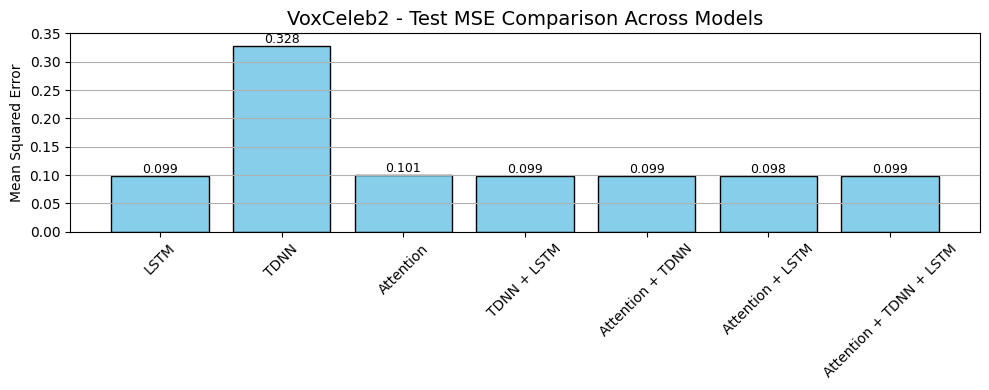

In [57]:
import matplotlib.pyplot as plt

model_names = [
    "LSTM",
    "TDNN",
    "Attention",
    "TDNN + LSTM",
    "Attention + TDNN",
    "Attention + LSTM",
    "Attention + TDNN + LSTM"
]

test_mse_values = [
    0.0991,   # LSTM
    0.3277,   # TDNN
    0.1005,   # Attention
    0.0989,   # TDNN + LSTM
    0.0990,   # Attention + TDNN
    0.0981,   # Attention + LSTM
    0.0988    # Attention + TDNN + LSTM
]

plt.figure()
bars = plt.bar(model_names, test_mse_values, color='skyblue', edgecolor='black')
plt.title("VoxCeleb2 - Test MSE Comparison Across Models", fontsize=14)
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=45)
plt.ylim(0, 0.35)
plt.grid(axis='y')

for bar, value in zip(bars, test_mse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.3f}",
             ha='center', va='bottom', fontsize=9)

plt.gcf().set_size_inches(10, 4)
plt.tight_layout()
plt.show()

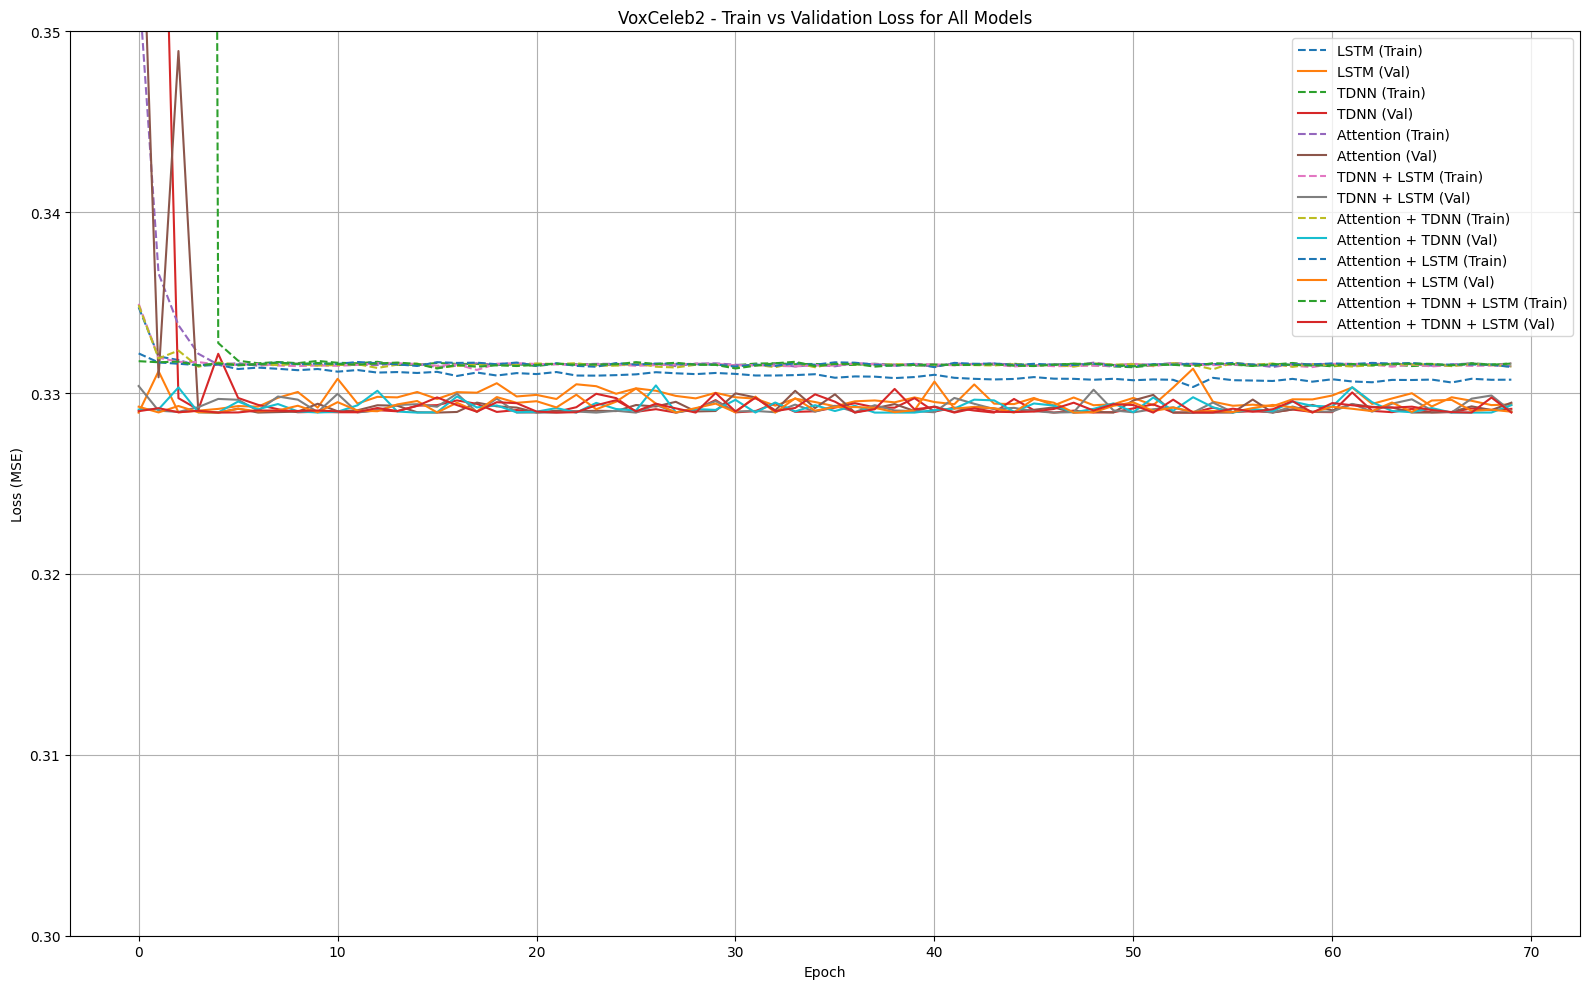

In [36]:
histories = {
    'LSTM': history_lstm,
    'TDNN': history_tdnn,
    'Attention': history_attn,
    'TDNN + LSTM': history_tdnn_lstm,
    'Attention + TDNN': history_attn_tdnn,
    'Attention + LSTM': history_attn_lstm,
    'Attention + TDNN + LSTM': history_final,
}

plt.figure(figsize=(16, 10))

for name, hist in histories.items():
    plt.plot(hist.history['loss'], linestyle='--', label=f'{name} (Train)')
    plt.plot(hist.history['val_loss'], linestyle='-', label=f'{name} (Val)')

plt.title("VoxCeleb2 - Train vs Validation Loss for All Models")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.ylim(0.3, 0.35)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()